# Advanced Lane Finding Project
## Detect lane pixels and fit to find the lane boundary.

### Importing libraries

In [84]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import os
from ipywidgets import interact, interactive
from moviepy.editor import VideoFileClip

%matplotlib inline

### Load Camera Calibration Data created in [Camera Calibration](camera_calibration.ipynb)

In [85]:
with open('outputs/camera_calibration.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

### Load Perspective Transform Matrix created in [Perspective Transform ](PerspectiveTransform.ipynb)

In [86]:
with open('outputs/perspective_transform_matrix.p', mode='rb') as f:
    mat_pickle = pickle.load(f)
    ptm = mat_pickle['ptm']
    ptm_inv = mat_pickle['ptm_inv']
    
def warper(img):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective( img, ptm, img_size, flags=cv2.INTER_LINEAR)

### Load Test Images

In [87]:
test_images = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), glob.glob('./test_images/*.jpg')))

### Combine the two binary thresholds HLS and Sobel
See  [Thresholded Binary Image](./Thresholded_Binary_Image.ipynb) to see the impact of parameter changes on the combile_thresholds function.

In [88]:
def combile_thresholds(img, sobelx_thresh=(20,100), s_thresh=(170,255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sx_binaray = np.zeros_like(scaled_sobel)
    sx_binaray[(scaled_sobel>=sobelx_thresh[0])&(scaled_sobel<=sobelx_thresh[1])] = 1
    
    his = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = his[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    combined_binary = np.zeros_like(sx_binaray)
    combined_binary[(s_binary == 1) | (sx_binaray == 1)] = 1
    return combined_binary

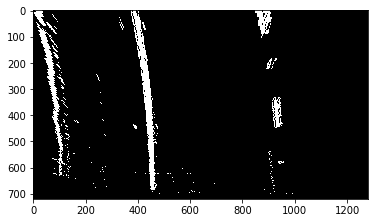

In [89]:
# Load our image
binary_warped = warper(combile_thresholds(test_images[3][1]))

plt.gray()
plt.imshow(binary_warped)

### Histogram for lane search

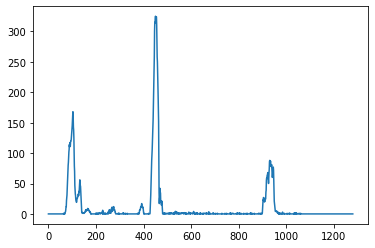

midpoint    = 640
leftx_base  = 450
rightx_base = 930


In [90]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print('midpoint    = {}'.format(midpoint))
print('leftx_base  = {}'.format(leftx_base))
print('rightx_base = {}'.format(rightx_base))

### Sliding window to fit a polynomial

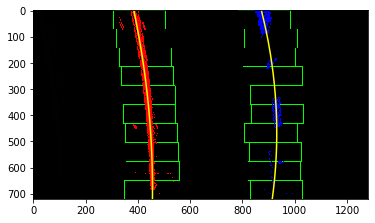

In [91]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

out_img = fit_polynomial(binary_warped)
plt.imshow(out_img)
plt.savefig('./outputs/fit_polynomial.png')

## Determine the curvature of the lane and vehicle position with respect to center.

In [92]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Define y-value where we want radius of curvature
# We'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = 719

def measure_curvature( left_fit, right_fit):
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

for test_image in test_images:
    binary_warped = warper(combile_thresholds(test_image[1]))
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad, right_curverad = measure_curvature( left_fit, right_fit)
    
    # Calculate vehicle center
    x_max = binary_warped.shape[1]*xm_per_pix
    y_max = binary_warped.shape[0]*ym_per_pix
    vehicle_center = x_max / 2
    line_left = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    line_right = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    line_middle = line_left + (line_right - line_left)/2
    vehicle_position = line_middle - vehicle_center
    
    print('Image : {}, Left : {:.2f} m, Right : {:.2f} m, Center : {:.2f}m'.format(test_image[0], left_curverad, right_curverad, vehicle_position))


Image : ./test_images\straight_lines1.jpg, Left : 8809.34 m, Right : 162901.77 m, Center : 0.08m
Image : ./test_images\straight_lines2.jpg, Left : 8197.53 m, Right : 201642.54 m, Center : 0.10m
Image : ./test_images\test1.jpg, Left : 1116.34 m, Right : 60550.05 m, Center : 0.13m
Image : ./test_images\test2.jpg, Left : 1070.67 m, Right : 612.19 m, Center : 0.24m
Image : ./test_images\test3.jpg, Left : 2092.80 m, Right : 984.98 m, Center : 0.17m
Image : ./test_images\test4.jpg, Left : 2639.15 m, Right : 562.93 m, Center : 0.33m
Image : ./test_images\test5.jpg, Left : 733.70 m, Right : 945.47 m, Center : 0.08m
Image : ./test_images\test6.jpg, Left : 1868.45 m, Right : 514.35 m, Center : 0.06m


## Warp the detected lane boundaries back onto the original image.

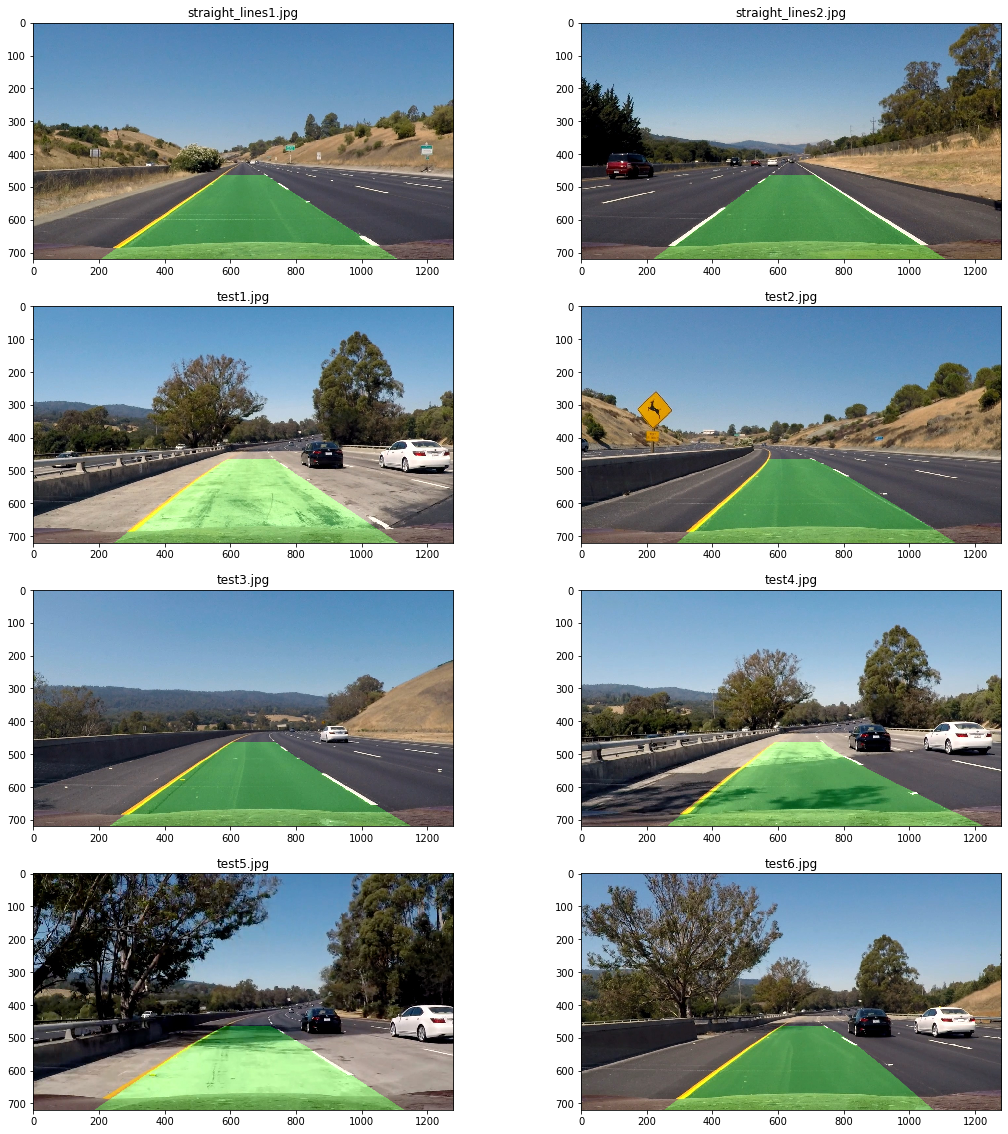

In [93]:
def drawLine(img, left_fit, right_fit):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
    y_max = img.shape[0]
    ploty = np.linspace(0, y_max - 1, y_max)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, ptm_inv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

def drawLaneOnImage(img):
    """
    Find and draw the lane lines on the image `img`.
    """
    binary_warped = warper(combile_thresholds(img))
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    output = drawLine(img, left_fit, right_fit)
    return cv2.cvtColor( output, cv2.COLOR_BGR2RGB )

plt.subplots(4, 2, figsize=(18,20))
for idx, test_image in enumerate(test_images):
    img = drawLaneOnImage(test_image[1])
    plt.subplot(4, 2, (idx+1))
    plt.title(os.path.basename(test_image[0]))
    plt.imshow(img)
plt.savefig('./outputs/draw_lane.png')
plt.show()

    
    

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

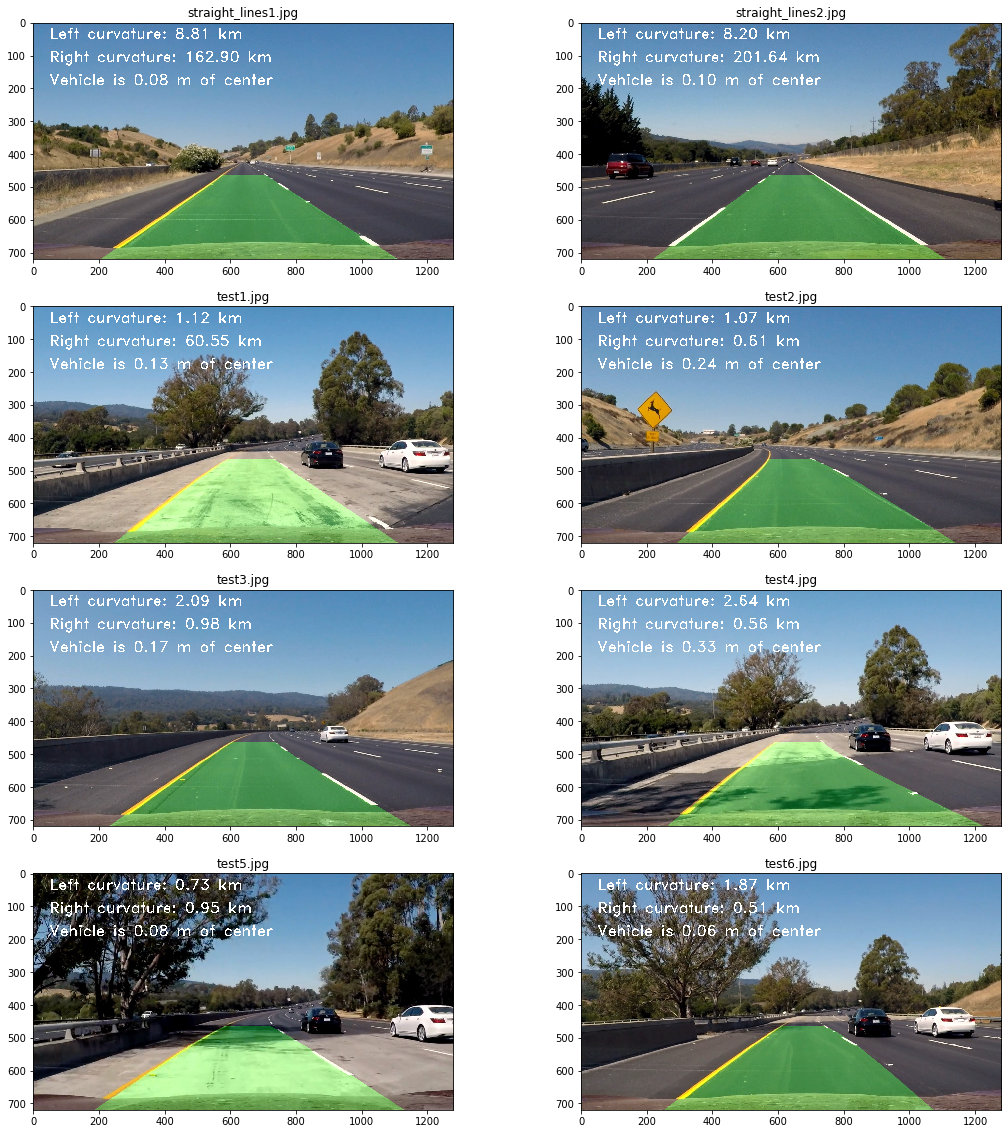

In [94]:
def drawData(ori_img, left_curverad, right_carverad, center_dist, fontScale=1.5):
    new_img = drawLaneOnImage(ori_img)
    font = cv2.FONT_HERSHEY_DUPLEX
    fontColor = (255, 255, 255)
    cv2.putText(new_img, 'Left curvature: {:.2f} km'.format(left_curverad/1000), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(new_img, 'Right curvature: {:.2f} km'.format(right_carverad/1000), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(new_img, 'Vehicle is {:.2f} m of center'.format(center_dist), (50, 190), font, fontScale, fontColor, 2)
    return new_img

plt.subplots(4, 2, figsize=(18,20))
for idx, test_image in enumerate(test_images):
    binary_warped = warper(combile_thresholds(test_image[1]))
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad, right_curverad = measure_curvature( left_fit, right_fit)
    
    # Calculate vehicle center
    x_max = binary_warped.shape[1]*xm_per_pix
    y_max = binary_warped.shape[0]*ym_per_pix
    vehicle_center = x_max / 2
    line_left = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    line_right = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    line_middle = line_left + (line_right - line_left)/2
    vehicle_position = line_middle - vehicle_center
    
    new_img = drawData(test_image[1], left_curverad, right_curverad, vehicle_position)
    
    plt.subplot(4, 2, (idx+1))
    plt.title(os.path.basename(test_image[0]))
    plt.imshow(new_img)
plt.show()


## Video pipeline

In [95]:
class Lane():
    def __init__(self):
        self.left_fit = 9999
        self.right_fit = 9999
        self.left_fit_m = 9999
        self.right_fit_m = 9999
        self.left_curverad = 9999
        self.right_curverad = 9999

def calculateLanes(img):
    """
    Calculates the lane on image `img`.
    """
    binary_warped = warper(combile_thresholds(img))
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad, right_curverad = measure_curvature( left_fit, right_fit)
    
    # Calculate vehicle center
    x_max = binary_warped.shape[1]*xm_per_pix
    y_max = binary_warped.shape[0]*ym_per_pix
    vehicle_center = x_max / 2
    line_left = left_fit_m[0]*y_max**2 + left_fit_m[1]*y_max + left_fit_m[2]
    line_right = right_fit_m[0]*y_max**2 + right_fit_m[1]*y_max + right_fit_m[2]
    line_middle = line_left + (line_right - line_left)/2
    vehicle_position = line_middle - vehicle_center

    return (left_fit, right_fit, left_fit_m, right_fit_m, left_curverad, right_curverad, vehicle_position)
    
def videoPipeline(inputVideo, outputVideo):
    """
    Process the `inputVideo` frame by frame to find the lane lines, draw curvarute and vehicle position information and
    generate `outputVideo`
    """
    myclip = VideoFileClip(inputVideo)
    
    leftLane = Lane()
    rightLane = Lane()
    
    def processImage(img):
        left_fit, right_fit, left_fit_m, right_fit_m, left_curverad, right_curverad, vehicle_position = calculateLanes(img)
        if left_curverad > 10000:
            left_fit = leftLane.left_fit
            left_fit_m = leftLane.left_fit_m
            left_curverad = leftLane.left_curverad
        else:
            leftLane.left_fit = left_fit
            leftLane.left_fit_m = left_fit_m
            leftLane.left_curverad = left_curverad
        
        if right_curverad > 10000:
            right_fit = rightLane.right_fit
            right_fit_m = rightLane.right_fit_m
            right_curverad = rightLane.right_curverad
        else:
            rightLane.right_fit = right_fit
            rightLane.right_fit_m = right_fit_m
            rightLane.right_curverad = right_curverad
        img = cv2.cvtColor( img, cv2.COLOR_BGR2RGB )
        return drawData(img, left_curverad, right_curverad, vehicle_position)

    clip = myclip.fl_image(processImage)
    clip.write_videofile(outputVideo, audio=False)

# Project video
videoPipeline('project_video.mp4', 'outputs/project_video.mp4')

t:   0%|                                                                    | 2/1260 [00:00<01:06, 18.78it/s, now=None]

Moviepy - Building video outputs/project_video.mp4.
Moviepy - Writing video outputs/project_video.mp4



Moviepy - Done !
Moviepy - video ready outputs/project_video.mp4
